## Explanatory Notebook for random data generation used for the training of a CNN for digit recognition in a sudoku grid:
<br>
<br>

In [1]:
from __future__ import print_function
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import glob
from scipy import ndimage, misc
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix


import itertools

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Create a cell with a digit in the center:

First we create a plain image with random light background
the insert a random digit in it and then we create some the lines around the cell.


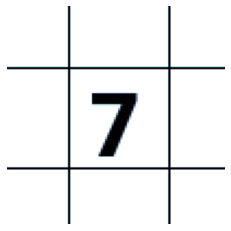

In [3]:

strip_width, strip_height = 100, 100

background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(80, 255), np.random.randint(80, 255), np.random.randint(80, 255)))

#font1 = ImageFont.truetype('/Library/Fonts/Arial.ttf', 40)
y=np.random.randint(0, 9+1) #Digit to write
y=7 # For this exemple we take 7
list_of_font=glob.glob('font2/*.ttf')
if y>0:
    text=str(y)
    #font = ImageFont.truetype('arial.ttf', 40)
    ff1=list_of_font[26]
    #print(ff1)
    font = ImageFont.truetype(ff1, 40)
    draw = ImageDraw.Draw(background)

    text_width, text_height = draw.textsize(text, font)
    
    position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
    color=(np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10))
    draw.text(position, text, color, font=font)
    #draw.text(position, str(y), color, font=font)
    

img=np.array(background)
#test_img=img
img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
img[:, [28, 74]]=1
img[[28, 74], :]=1
test_img=img #Save the test image for further use.

plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()



## Next we want to select random area of same size around the digit to account for imprecise cell separation in the algorithm

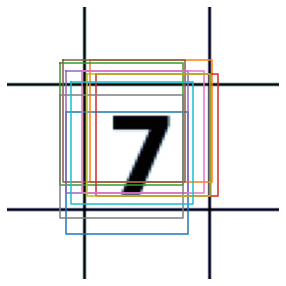

In [4]:
cell_size=45 #size of the cell we want to select
plt.figure(figsize=(5,5)) 
for i in range(0, 10):
    x=np.random.randint(19, 40) #to change.......
    y=np.random.randint(19, 40)
    x2=[x, x+cell_size, x+cell_size, x, x]
    y2=[y, y, y+cell_size, y+cell_size, y]
    plt.plot(x2, y2)

plt.imshow(img, cmap='bone')
plt.savefig('plots/cell_selection.png')
plt.axis('off')
plt.show()

## Add noise and elastic deformation:

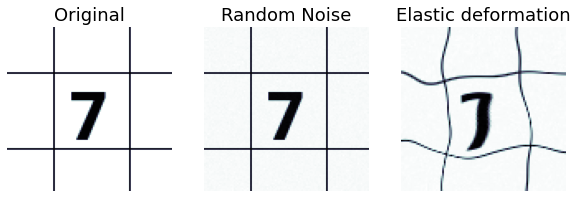

In [5]:
#from scipy.ndimage.interpolation import map_coordinates
#from scipy.ndimage.filters import gaussian_filter

def add_noise(img):
    row, col=np.shape(img)
    #mean = np.random.randint(0, 10)
    mean=10
    var = np.random.randint(1, 2)
    #print(var)
    #print(mean)
    sigma = var**0.01
    sigma = var**.1
    gauss = np.array((row, col))
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy.astype('uint8')

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)


img2=add_noise(img)
#img2=img
img3=elastic_transform(img2, 200, 10)

f = plt.figure(figsize=(10,20))
f.add_subplot(1,3, 1)
plt.imshow(img, cmap='bone')
plt.title('Original',fontsize=18)
plt.axis('off')
f.add_subplot(1,3, 2)
plt.imshow(img2, cmap='bone')
plt.title('Random Noise',fontsize=18)
plt.axis('off')

f.add_subplot(1,3, 3)
plt.imshow(img3, cmap='bone')
plt.title('Elastic deformation',fontsize=18)
#plt.show(block=True)
plt.axis('off')
plt.savefig('plots/noisy_images.png', bbox_inches='tight')
plt.show()

## All script:

<br>
for the (synthetic) training dataset, we added rotation between 10° and -10 °.
The data was also created as to reflect "real life" unbalance meaning that a lot more "0" are present on a grid than "true" digits. 



In [6]:

def rotate_img(img): #Rotate image with random angle between 0 and 10 degrees, fill unasigned corners with random [0.6-1]
    from scipy import ndimage, misc
    angle=np.random.randint(0, 20)-10
    random_background=np.random.randint(150, 255)
    img_rot = ndimage.rotate(img, angle, reshape=False, cval=random_background)
    return img_rot

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

    
def add_noise(img):
    row, col=np.shape(img)
    mean = np.random.randint(0, 10)
    var = np.random.randint(1, 2)
    #print(var)
    #print(mean)
    sigma = var**0.01
    gauss = np.array((row, col))
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy.astype('uint8')

def get_image_part(img, cell_size):
    x=np.random.randint(12, 46)
    y=np.random.randint(12, 46)
    img=img[x:x+cell_size, y:y+cell_size]
    return img


def create_data(length, list_of_font, threshold=True, consider_empty=True):
    cell_size=45
    y_label=np.zeros(length, dtype=int)
    
    x_img=np.zeros((length, cell_size, cell_size), dtype=float)
    for i in range(0, length):
    
        
        if consider_empty:
            y=np.random.randint(-9, 9+1)
        
        else:
            y=np.random.randint(1, 9+1)
        
        if y<1:
            y_label[i]=0
            
        else:
            y_label[i]=y
            text=str(y)
        
        strip_width, strip_height = 100, 100

        background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(160, 255), np.random.randint(160, 255), np.random.randint(160, 255)))
        font1=list_of_font[np.random.randint(0, len(list_of_font))]
        #print(font1)
        
        font = ImageFont.truetype(font1, 40)
        draw = ImageDraw.Draw(background)
        
        
        if y>0:
            text=str(y)
            text_width, text_height = draw.textsize(text, font)
            position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
            color=(np.random.randint(0, 20), np.random.randint(0, 20), np.random.randint(0, 20))
            draw.text(position, str(y), color, font=font)
           
        img=np.array(background)
        img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
        bar_w=np.random.randint(1, 4)
        img[:, 28:28+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[:, 74:74+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[28:28+bar_w, :]=1
        bar_w=np.random.randint(1, 4)
        img[74:74+bar_w, :]=1
        img=get_image_part(img, cell_size)
        img=rotate_img(img) #randomly rotate image
        
        img=add_noise(img)
        lst_radius=[3, 5, 7, 9, 11, 13]
        radii=lst_radius[np.random.randint(0, 5)]
        
        img = cv2.GaussianBlur(img, (radii, radii), 0)#
        img=elastic_transform(img, np.random.randint(0, 80), np.random.randint(5, 10), random_state=None)
                
        x_img[i, :, :]=img
    return x_img, y_label
        
        
#list_of_font=['arial.ttf', 'Courier New.ttf', 'Times New Roman.ttf']
list_of_font=glob.glob('font2/*.ttf')


n=40000 #Number of image to generate
#n=50
xx, yy=create_data(n, list_of_font, False)

<br>

## Plot results of data Generation:

<br>
<br>

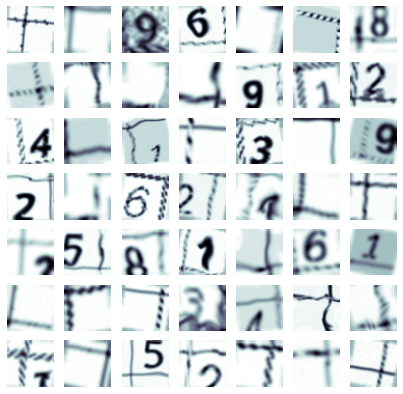

In [7]:
f = plt.figure(figsize=(7,7))

num_img=49
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(xx[i, :, :], cmap='bone')
    plt.axis('off')

plt.savefig('plots/digits1.png' , bbox_inches='tight')
plt.show()

## Train the Network:
<br>
<br>
Model building and training:
<br>


In [8]:

#validation Data:
y_test_path='data_npy/tot_labels43.npy'
x_test_path='data_npy/tot_img43.npy'
yy_lab=np.load(y_test_path)
y_test=np.array(yy_lab)
x_test=np.load(x_test_path)

num_classes=10
#y_test = keras.utils.to_categorical(yy_lab, num_classes)
x_train=xx
y_train=yy
print(np.shape(x_train))
x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))


(40000, 45, 45)
(40000, 45, 45, 1)
3483


In [9]:


#x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.1)

cell_size=45
batch_size = 128
num_classes = len(np.unique(yy))
epochs = 20

# input image dimensions
img_rows, img_cols = cell_size, cell_size


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
####x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = Sequential()
model.add(Conv2D(32, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)


model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])


history_train=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (40000, 45, 45, 1)
40000 train samples
3483 test samples
Epoch 1/20
313/313 [==============================] - 15s 49ms/step - loss: 1.4420 - accuracy: 0.5410 - val_loss: 0.9047 - val_accuracy: 0.6882
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 1.2128 - accuracy: 0.5739 - val_loss: 1.1547 - val_accuracy: 0.6270
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 1.1140 - accuracy: 0.6006 - val_loss: 1.3347 - val_accuracy: 0.5673
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 1.0507 - accuracy: 0.6216 - val_loss: 1.0328 - val_accuracy: 0.6512
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 0.9788 - accuracy: 0.6462 - val_loss: 0.9910 - val_accuracy: 0.6802
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 0.9115 - accuracy: 0.6726 - val_loss: 1.8373 - val_accuracy: 0.4780
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 

## Plot the training and testing loss and accuracy:

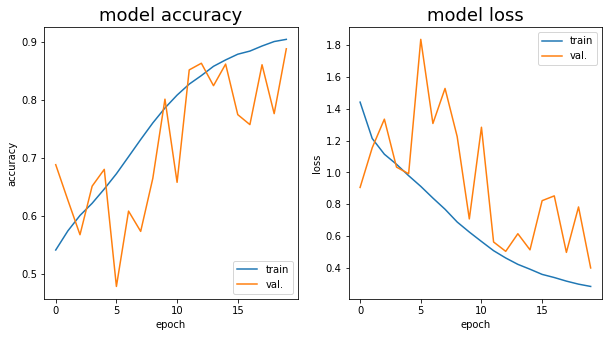

In [10]:

f = plt.figure(figsize=(10,5))
f.add_subplot(1,2, 1)
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='lower right')

f.add_subplot(1,2, 2)
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss',fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper right')
plt.savefig('plots/training_stats1.png' , bbox_inches='tight')

plt.show()



# Save model for further use:

In [11]:
model.save("models/digit_recognition_model_x1.h5")

## Validation set from real sudoku grids:

<br>
<br>

Here we try to access how robust our model is in recognising cell images extracted from several real sudoku  grids. The sudoku images we used are available in the  sample_img  folder and the cell areas have been extracted following the process shown on the sgrid_detection.ipynb Notebook.

<br>


In [12]:
#Load data from real sudoku grids:

yy_lab=np.load(y_test_path)
yy_lab=np.array(yy_lab)
raw_img=np.load(x_test_path)
xx_1=raw_img

In [13]:
y_x = tf.keras.utils.to_categorical(yy_lab, num_classes)
#Returns the loss value & metrics values for the model in test mode.
lo, acc=model.evaluate(xx_1, y_x, batch_size=81)
print('accuracy: ', round(acc, 4))

43/43 [==============================] - 0s 3ms/step - loss: 0.3977 - accuracy: 0.8883
accuracy:  0.8883


The model is performing not too bad but we can do even better by in the training data as we will see...

In [14]:
pred=model.predict(x_test)
y_pred=pred.argmax(1)
print(y_pred)

[0 0 0 ... 0 0 0]


## Confusion Matrix:

<br>
<br>

In [15]:

matrix = confusion_matrix(yy_lab, y_pred)
print(matrix)


[[2046    1   18   50    1   56   46   22   56   11]
 [   0  114    0    9    1    0    0    0    0    0]
 [   0    7  122    5    0    0    0    0    0    0]
 [   0    2    0  133    0    0    0    0    3    1]
 [   0   18    1    0   99    0    4    0    1    0]
 [   0    1    0   14    0  133    0    0    0    0]
 [   0    1    1    2    3    5   97    0    6    7]
 [   0    7    3    0    0    0    0  131    0    0]
 [   0    4    0    6    2    0    0    0  117    8]
 [   0    2    0    3    0    0    0    0    1  102]]


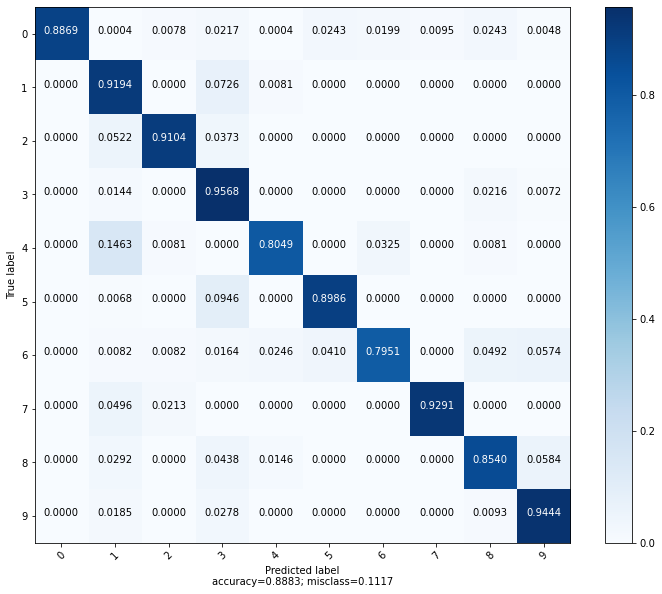

In [16]:
#Normalized Confusion Matrix:

cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


cm=matrix
normalize=True
target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cmap=None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#plt.title(title)
plt.colorbar()

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('plots/conf_matrix_first_training.png' , bbox_inches='tight')
plt.show()

<br>

## Display failed recogntions:

<br>
<br>

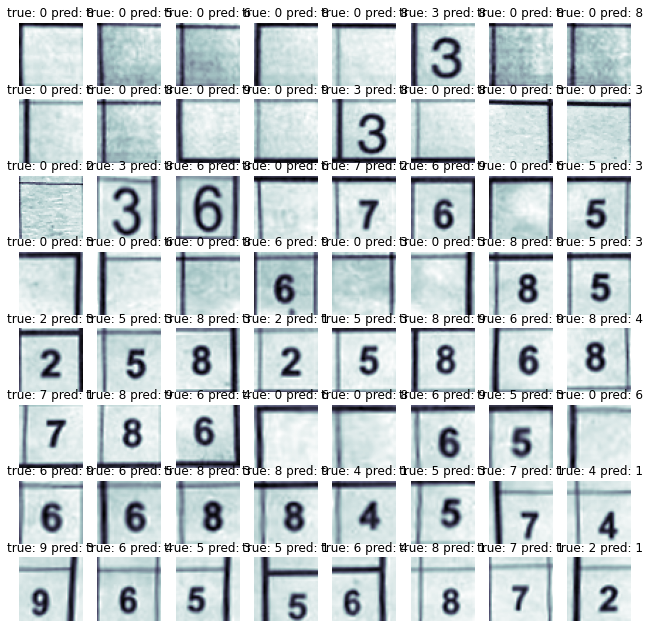

389


In [17]:
k=0
cell_size=45
true=[]
predicted=[]
j=0
gr_t=1
grid=[]
lst_index=[]
for i in range(0, len(y_pred)):
    if y_pred[i]!= yy_lab[i]:
        k=k+1
        lst_index.append(i)
        true.append(yy_lab[i])
        predicted.append(y_pred[i])
        #print(yy_lab[i])
        if j>80:
            gr_t=gr_t+1
            j=0
        grid.append(gr_t)
        
    
    j=j+1
        
        
        

failed=np.zeros((k, cell_size, cell_size), dtype=float)

for i in range(0, len(lst_index)):
    img=x_test[lst_index[i], :, :, 0]
    failed[i, :, :]=img
    #true.append(yy_lab[lst_index[i]])
    #predicted.append(y_pred[lst_index[i]])


num_img=64
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


f = plt.figure(figsize=(11,11))
for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(failed[i, :, :], cmap='bone')
    #tt='pred: '+str(predicted[i])
    tt='true: '+str(true[i])+' pred: '+str(predicted[i])
    plt.title(tt,fontsize=12)
    plt.axis('off')

plt.savefig('plots/failed_digitsx.png' , bbox_inches='tight')
plt.show()
print(k)

We can see that our trained model fails to recognize images with digits of differents sizes.
<br>
We will habe to add some variation in the digit size to the training set.
<br>
The failed recognitions also have local noise probably type salt and pepper and Perlin noise.
<br>
This ispossibly due to change in light exposure when the picture was taken or the quality of the camera.
<br>
Indeed if we use adaptative threshold on those images:
<br>

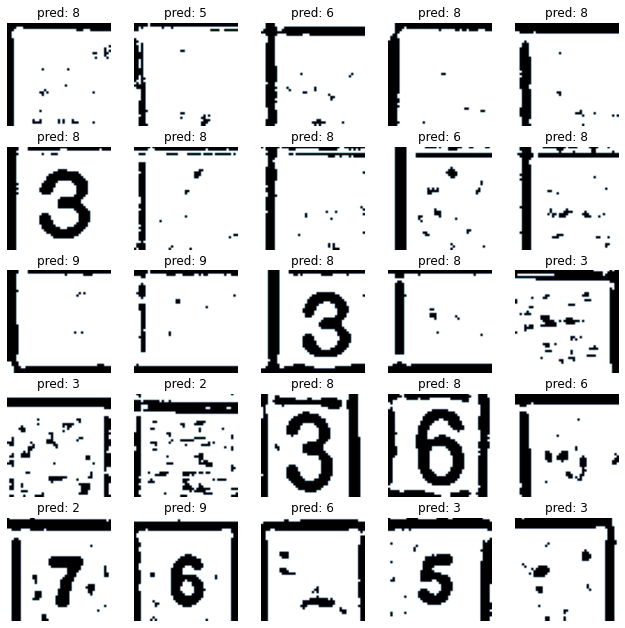

In [18]:
num_img=25
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))

f = plt.figure(figsize=(11,11))
for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    img=failed[i, :, :]*255
   
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(img, kernel, iterations = 1)
    dilation = cv2.dilate(erosion, kernel, iterations = 1)
    #img2=np.expand_dims(dilation, axis=-1)
    #img2=np.expand_dims(img2, axis=0)
    #pred2=model.predict(img2)
    #y_pred=pred2.argmax(1)
    #print(y_pred, true[i])
    
    img = cv2.blur(img,(5, 5), 0).astype('uint8')
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    plt.imshow(thresh, cmap='bone')
    tt='pred: '+str(predicted[i])
    #tt='true: '+str(true[i])+' pred: '+str(predicted[i])
    plt.title(tt,fontsize=12)
    plt.axis('off')

plt.savefig('plots/failed_digits1_tresh.png' , bbox_inches='tight')
plt.show()

## Add Perlin Noise: 

We can see some patch of noise in the image which could be responsible for fooling the algorithm.
<br>
Basically there are two diffrent approach to solve this issue: 
<br>
* Either we increase the preprosessing step in the extracted images in order to eliminate this noise before analysis.
<br>
* Or we reproduce this kind of noise for the training data.
<br>
The first approach would require some simple morphological operation such as errosion and dilatation but here we would like to increase our neural network performance so let's focus on the second aproach.
To achieve this we will try to add localized perturbation to our training images, the kind of disturbances we will try are called Perlin noise and salt and Pepper:
<br>


/home/simon/anaconda3/envs/simenv/lib/python3.7/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


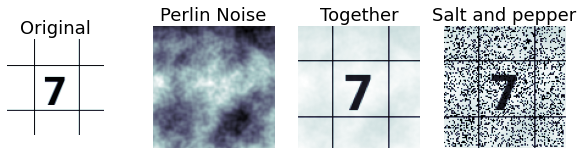

In [19]:
import noise # New package needed for perlin noise.

def test_perlin_noise(img):
    shape = np.shape(img)[0], np.shape(img)[1]
    scale=900
    octaves=6
 
    persistence=0.5
    lacunarity=30
    lacunarity=3
    noisy = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noisy[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)
    noisy=noisy*250
    img2=img+noisy
    img2=np.minimum(255, img2)
    img2=np.maximum(0, img2)
    return img2, noisy




def salt_pepper(image):
    
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.3
    out = np.copy(image)
        # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    #out[coords] = 1
    out[tuple(coords)] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    #out[coords] = 0
    out[tuple(coords)] =0
    return out


im1, im2=test_perlin_noise(test_img)
im3=salt_pepper(im1)

#plt.imshow(test_img)
#plt.show()
f = plt.figure(figsize=(10,20))
f.add_subplot(1,5, 1)
plt.imshow(test_img, cmap='bone')
plt.title('Original',fontsize=18)
plt.axis('off')
f.add_subplot(1,4, 2)
plt.imshow(im2, cmap='bone')
plt.title('Perlin Noise',fontsize=18)
plt.axis('off')

f.add_subplot(1,4, 3)
plt.imshow(im1, cmap='bone')
plt.title('Together',fontsize=18)
#plt.show(block=True)
plt.axis('off')
#plt.savefig('noisy_images.png', bbox_inches='tight')

f.add_subplot(1,4, 3)
plt.imshow(im1, cmap='bone')
plt.title('Together',fontsize=18)
#plt.show(block=True)
plt.axis('off')
#plt.savefig('noisy_images.png', bbox_inches='tight')


f.add_subplot(1,4, 4)
plt.imshow(im3, cmap='bone')
plt.title('Salt and pepper',fontsize=18)
#plt.show(block=True)
plt.axis('off')
plt.savefig('plots/added_noise2.png' , bbox_inches='tight')
plt.show()






And if we wrap this up with everything we have used befor for our training data generation:

<br>
Note that we also corrected the data imbalance closer to the true representation (around 70% of empty cells)
<br>

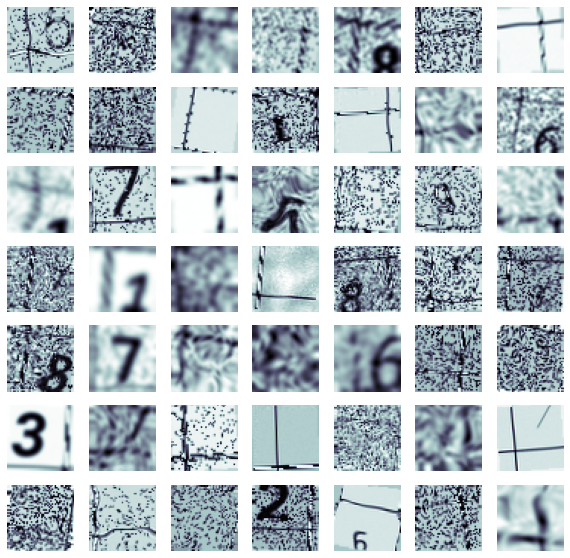

In [20]:
import noise

def perlin_noise(img):
 
    shape = np.shape(img)[0], np.shape(img)[1]
    scale = np.random.randint(1, 1500)
    
    octaves=np.random.randint(4, 15)
   
 
    persistence=np.random.random_sample()*25
    #persistence=np.random.randint(1, 20)
    #lacunarity = 1.0
    #lacunarity=100
    lacunarity=(np.random.random_sample()+0.2)*100

    noisy = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noisy[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)
    noisy=noisy*255
    img2=img+noisy
    
    img2=np.minimum(255, img2)
    img2=np.maximum(0, img2)
    #print(np.max(img2))
    #print(np.min(img2))
    return img2




def salt_pepper(image):
    
    row,col = image.shape
    s_vs_p = np.random.randint(0, 9)/10
    amount = np.random.randint(0, 5)/10
    out = np.copy(image)
        # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    #out[coords] = 1
    out[tuple(coords)] = np.random.randint(0, 10)/10

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    #out[coords] = 0
    out[tuple(coords)] =np.random.randint(0, 10)/10
    return out


def create_data2(length, list_of_font, threshold=True, consider_empty=True):
    cell_size=45
    y_label=np.zeros(length, dtype=int)
    
    x_img=np.zeros((length, cell_size, cell_size), dtype=float)
    for i in range(0, length):
    
        
        if consider_empty:
            y=np.random.randint(-20, 9+1)
        
        else:
            y=np.random.randint(1, 9+1)
        
        if y<1:
            y_label[i]=0
            
        else:
            y_label[i]=y
            text=str(y)
        
        strip_width, strip_height = 100, 100

        background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(160, 255), np.random.randint(160, 255), np.random.randint(160, 255)))
        font1=list_of_font[np.random.randint(0, len(list_of_font))]
        #print(font1)
        
        text_size=np.random.randint(18, 55)
        font = ImageFont.truetype(font1, text_size)
        draw = ImageDraw.Draw(background)
        
        
        if y>0:
            text=str(y)
            text_width, text_height = draw.textsize(text, font)
            position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
            color=(np.random.randint(0, 20), np.random.randint(0, 20), np.random.randint(0, 20))
            draw.text(position, str(y), color, font=font)
           
        img=np.array(background)
        img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
        bar_w=np.random.randint(1, 4)
        img[:, 28:28+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[:, 74:74+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[28:28+bar_w, :]=1
        bar_w=np.random.randint(1, 4)
        img[74:74+bar_w, :]=1
        img=get_image_part(img, cell_size)
        img=rotate_img(img) #randomly rotate image
        
        img=add_noise(img)
        img=perlin_noise(img)
        img=salt_pepper(img)
        
        lst_radius=[3, 5, 7, 9, 11, 13]
        radii=lst_radius[np.random.randint(0, 5)]
        
        if np.random.random_sample()>0.6:
            img = cv2.GaussianBlur(img, (radii, radii), 0)
            
        img=elastic_transform(img, np.random.randint(0, 80), np.random.randint(5, 10), random_state=None)
                
        x_img[i, :, :]=img
        #plt.imshow(img, cmap='bone')
        #plt.show()
        
    return x_img, y_label


n=52000 #Number of image to generate
#n=60
list_of_font=glob.glob('font2/*.ttf')

xx, yy=create_data2(n, list_of_font, False)

f = plt.figure(figsize=(10,10))

num_img=49
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(xx[i, :, :], cmap='bone')
    plt.axis('off')

#plt.savefig('plots/digits4.png' , bbox_inches='tight')
plt.show()

In [21]:

#validation Data:
yy_lab=np.load('data_npy/tot_labels33.npy')
y_test=np.array(yy_lab)
x_test=np.load('data_npy/tot_img33.npy')

num_classes=10
#y_test = keras.utils.to_categorical(yy_lab, num_classes)
x_train=xx
y_train=yy
print(np.shape(x_train))
x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))

(52000, 45, 45)
(52000, 45, 45, 1)
2673


In [22]:
cell_size=45
batch_size = 128
num_classes = len(np.unique(yy))
epochs = 25

# input image dimensions
img_rows, img_cols = cell_size, cell_size


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
####x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = Sequential()
model.add(Conv2D(32, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
#opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)

opt=tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy']) # ! Unbalanced sample (more 0s)

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=opt,
#              metrics=['accuracy'])


history_train=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (52000, 45, 45, 1)
52000 train samples
2673 test samples
Epoch 1/25
407/407 [==============================] - 14s 34ms/step - loss: 1.0082 - accuracy: 0.7172 - val_loss: 0.6781 - val_accuracy: 0.7535
Epoch 2/25
407/407 [==============================] - 3s 9ms/step - loss: 0.7487 - accuracy: 0.7591 - val_loss: 0.4268 - val_accuracy: 0.9020
Epoch 3/25
407/407 [==============================] - 3s 9ms/step - loss: 0.6274 - accuracy: 0.8003 - val_loss: 0.1865 - val_accuracy: 0.9536
Epoch 4/25
407/407 [==============================] - 3s 9ms/step - loss: 0.5179 - accuracy: 0.8378 - val_loss: 0.1448 - val_accuracy: 0.9686
Epoch 5/25
407/407 [==============================] - 4s 9ms/step - loss: 0.4365 - accuracy: 0.8667 - val_loss: 0.0730 - val_accuracy: 0.9820
Epoch 6/25
407/407 [==============================] - 4s 9ms/step - loss: 0.3730 - accuracy: 0.8858 - val_loss: 0.0347 - val_accuracy: 0.9903
Epoch 7/25
407/407 [==============================] - 4s 9ms/step - loss: 

In [23]:
pred=model.predict(x_test)
y_pred=pred.argmax(1)
print(y_pred)

matrix = confusion_matrix(yy_lab, y_pred)

cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)
#print(cm_normalized )

[0 0 0 ... 0 0 0]
[[1762    0    0    0    0    0    0    0    0    0]
 [   0   90    0    0    0    0    0    0    0    0]
 [   0    0  108    0    0    0    0    0    0    0]
 [   0    0    0  116    0    0    0    0    0    0]
 [   0    0    0    0   85    0    4    0    0    0]
 [   0    0    0    0    0  119    0    0    0    0]
 [   0    0    0    0    0    0   96    0    0    0]
 [   0    1    0    0    0    0    0  107    0    0]
 [   0    0    0    0    0    0    0    0  103    0]
 [   0    0    0    0    0    0    0    0    2   80]]


In [24]:
model.save("models/digit_recognition_model9974.h5")

In [25]:
#Compare histogram density of training and test set

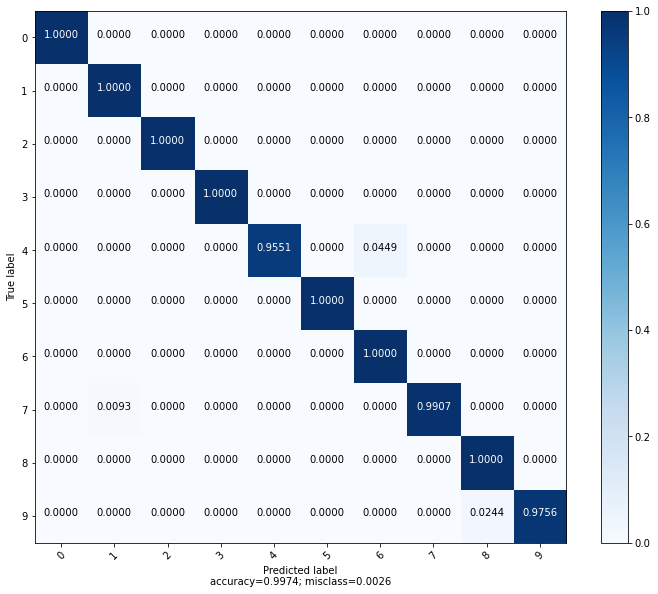

In [26]:

cm=matrix
normalize=True
target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


import matplotlib.pyplot as plt
import numpy as np
import itertools
cmap=None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#plt.title(title)
plt.colorbar()

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('plots/conf_matrix3.png' , bbox_inches='tight')
plt.show()

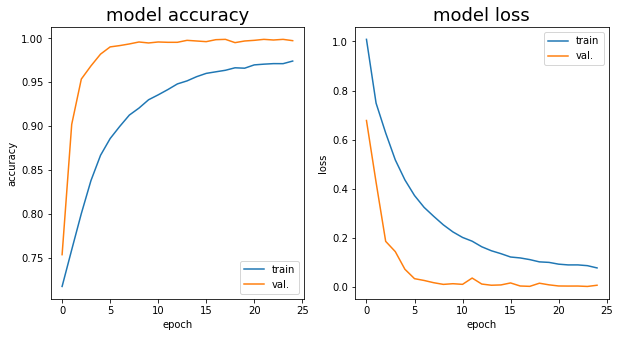

In [27]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2, 1)
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='lower right')

f.add_subplot(1,2, 2)
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss',fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper right')
plt.savefig('plots/training_stats2.png' , bbox_inches='tight')

plt.show()

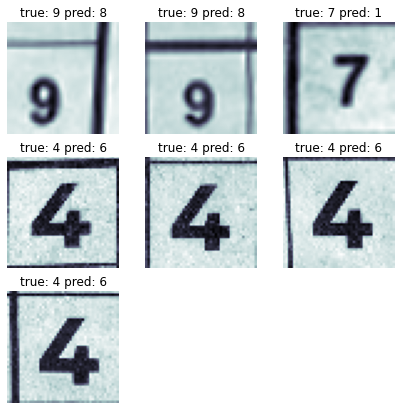

7


In [28]:
k=0
cell_size=45
true=[]
predicted=[]
j=0
gr_t=1
grid=[]
lst_index=[]
for i in range(0, len(y_pred)):
    if y_pred[i]!= yy_lab[i]:
        k=k+1
        lst_index.append(i)
        true.append(yy_lab[i])
        predicted.append(y_pred[i])
        #print(yy_lab[i])
        if j>80:
            gr_t=gr_t+1
            j=0
        grid.append(gr_t)
        
    
    j=j+1
        
        
        

failed=np.zeros((k, cell_size, cell_size), dtype=float)

for i in range(0, len(lst_index)):
    img=x_test[lst_index[i], :, :, 0]
    failed[i, :, :]=img
    #true.append(yy_lab[lst_index[i]])
    #predicted.append(y_pred[lst_index[i]])


num_img=k
#n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))
n, m=3, 3

f = plt.figure(figsize=(7,7))
for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(failed[i-1, :, :], cmap='bone')
    #tt='pred: '+str(predicted[i])
    tt='true: '+str(true[i-1])+' pred: '+str(predicted[i-1])
    plt.title(tt,fontsize=12)
    plt.axis('off')

plt.savefig('plots/failed_digits2.png' , bbox_inches='tight')
plt.show()
print(k)

ok so it might be worth it to include more fonts that display the number 4 in that particular style...
<br>
<br>

## Transfer Learning:
<br>

In this section we will try to increase our accuracy even further by using pre trained models.
<br>
Those Models have the advantages of having already learned the useful features for image recognition tasks
<br>
This also have the added benefit of deacreasing the training time.
<br>
<br>

In [ ]:
#create new data

list_of_font=glob.glob('font2/*.ttf')
print(len(list_of_font))
xx, yy=create_data2(45000, list_of_font, False)



49


In [29]:
def increase_chanel(gray_array):
    new_array = np.repeat(gray_array[..., np.newaxis], 3, -1)
    return new_array

yy_lab=np.load('data_npy/tot_labels33.npy')
y_test=np.array(yy_lab)
x_test=np.load('data_npy/tot_img33.npy')

num_classes=10
#y_test = keras.utils.to_categorical(yy_lab, num_classes)
x_train=xx
y_train=yy
print(np.shape(x_train))
#x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255

x_test=x_test[:, :, :, 0]
x_test=increase_chanel(x_test)
x_train=increase_chanel(x_train)

print(np.shape(x_train))
print(np.shape(x_test))

(45000, 45, 45)
(45000, 45, 45)
2673
(45000, 45, 45, 3)
(2673, 45, 45, 3)


In [36]:

#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Activation
#from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

inputShape=(45, 45, 3)
classes=10
#base_model = MobileNet(weights='imagenet', include_top=False, input_shape=inputShape)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=inputShape)
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=inputShape)



x = base_model.output

# define classification layers
x = Flatten()(x)
x = Dense(classes)(x)
preds = Activation("softmax")(x)

#
model = Model(inputs=base_model.input, outputs=preds)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 45, 45, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 45, 45, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 45, 45, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 22, 22, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 22, 22, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 22, 22, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 11, 11, 128)       0   

In [37]:



batch_size=100
epochs=16

opt=tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy']) # ! Unbalanced sample (more 0s)

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=opt,
#              metrics=['accuracy'])


history_train=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/16
450/450 [==============================] - 16s 37ms/step - loss: 0.8945 - accuracy: 0.7229 - val_loss: 0.7400 - val_accuracy: 0.7276
Epoch 2/16
450/450 [==============================] - 17s 37ms/step - loss: 0.5133 - accuracy: 0.8173 - val_loss: 0.1420 - val_accuracy: 0.9458
Epoch 3/16
450/450 [==============================] - 17s 37ms/step - loss: 0.3286 - accuracy: 0.8965 - val_loss: 0.0212 - val_accuracy: 0.9974
Epoch 4/16
450/450 [==============================] - 17s 37ms/step - loss: 0.2347 - accuracy: 0.9323 - val_loss: 0.0036 - val_accuracy: 0.9996
Epoch 5/16
450/450 [==============================] - 17s 37ms/step - loss: 0.1857 - accuracy: 0.9494 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 6/16
450/450 [==============================] - 17s 38ms/step - loss: 0.1617 - accuracy: 0.9568 - val_loss: 0.0210 - val_accuracy: 0.9966
Epoch 7/16
450/450 [==============================] - 17s 38ms/step - loss: 0.1416 - accuracy: 0.9618 - val_loss: 0.0202 - val_accuracy:

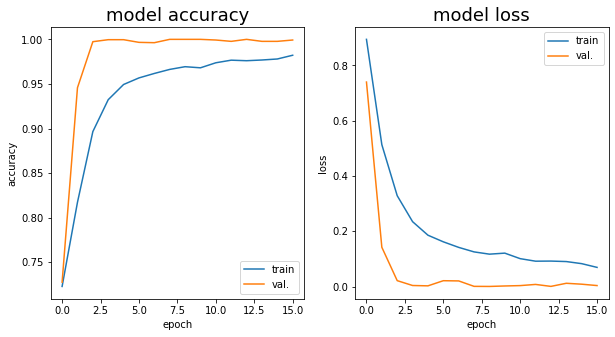

In [38]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2, 1)
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='lower right')

f.add_subplot(1,2, 2)
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss',fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper right')
plt.savefig('plots/training_stats3.png' , bbox_inches='tight')

plt.show()

In [39]:
pred=model.predict(x_test)
y_pred=pred.argmax(1)
print(y_pred)

matrix = confusion_matrix(yy_lab, y_pred)

cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)
#print(cm_normalized )

[0 0 0 ... 0 0 0]
[[1762    0    0    0    0    0    0    0    0    0]
 [   0   90    0    0    0    0    0    0    0    0]
 [   0    0  108    0    0    0    0    0    0    0]
 [   0    0    0  116    0    0    0    0    0    0]
 [   0    0    0    0   87    0    0    0    0    2]
 [   0    0    0    0    0  119    0    0    0    0]
 [   0    0    0    0    0    0   96    0    0    0]
 [   0    0    0    0    0    0    0  108    0    0]
 [   0    0    0    0    0    0    0    0  103    0]
 [   0    0    0    0    0    0    0    0    0   82]]


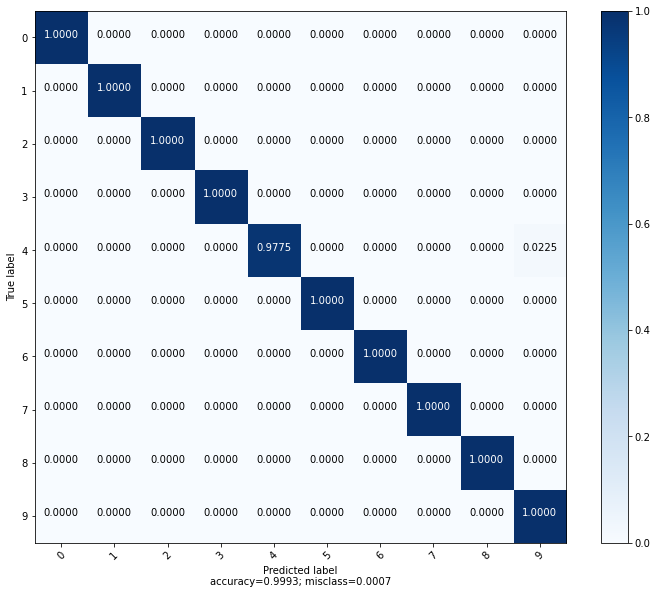

In [40]:

cm=matrix
normalize=True
target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


import matplotlib.pyplot as plt
import numpy as np
import itertools
cmap=None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#plt.title(title)
plt.colorbar()

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('plots/conf_matrix4.png' , bbox_inches='tight')
plt.show()

In [112]:
#model.save("models/digit_recognition_model998.h5")

9
4


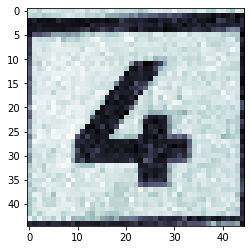

9
4


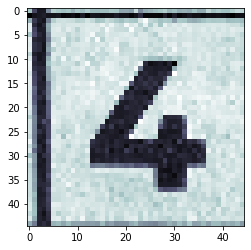

2


In [41]:
k=0
cell_size=45
true=[]
predicted=[]
j=0
gr_t=1
grid=[]
lst_index=[]
for i in range(0, len(y_pred)):
    if y_pred[i]!= yy_lab[i]:
        k=k+1
        lst_index.append(i)
        true.append(yy_lab[i])
        predicted.append(y_pred[i])
        #print(yy_lab[i])
        if j>80:
            gr_t=gr_t+1
            j=0
        grid.append(gr_t)
        
    
    j=j+1
        
        
        

failed=np.zeros((k, cell_size, cell_size), dtype=float)

for i in range(0, len(lst_index)):
    img=x_test[lst_index[i], :, :, 0]
    failed[i, :, :]=img
    #true.append(yy_lab[lst_index[i]])
    #predicted.append(y_pred[lst_index[i]])


num_img=4
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


#f = plt.figure(figsize=(11,11))
for i in range(0, k):
    #f.add_subplot(n,m, i)
    #plt.imshow(failed[i, :, :], cmap='bone')
    print(predicted[i])
    print(true[i])
    plt.imshow(failed[i, :, :], cmap='bone')
    plt.show()
    #tt='pred: '+str(predicted[i])
    #tt='true: '+str(true[i])+' pred: '+str(predicted[i])
    #plt.title(tt,fontsize=12)
    #plt.axis('off')

    
#plt.imshow(failed[i, :, :], cmap='bone')
#plt.savefig('plots/failed_digits2.png' , bbox_inches='tight')
#plt.show()
print(k)

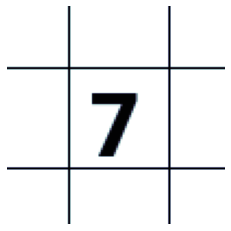

In [43]:
strip_width, strip_height = 100, 100

background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(80, 255), np.random.randint(80, 255), np.random.randint(80, 255)))

#font1 = ImageFont.truetype('/Library/Fonts/Arial.ttf', 40)
y=np.random.randint(0, 9+1) #Digit to write
y=7 # For this exemple we take 7
list_of_font=glob.glob('font2/*.ttf')
if y>0:
    text=str(y)
    #font = ImageFont.truetype('arial.ttf', 40)
    ff1=list_of_font[26]
    #print(ff1)
    font = ImageFont.truetype(ff1, 40)
    draw = ImageDraw.Draw(background)

    text_width, text_height = draw.textsize(text, font)
    
    position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
    color=(np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10))
    draw.text(position, text, color, font=font)
    #draw.text(position, str(y), color, font=font)
    

img=np.array(background)
#test_img=img
img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
img[:, [28, 74]]=1
img[[28, 74], :]=1
test_img=img #Save the test image for further use.

plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()




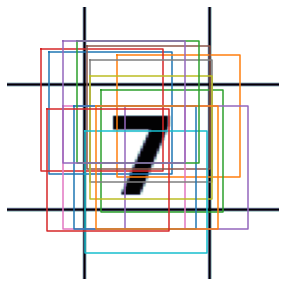

In [44]:
cell_size=45 #size of the cell we want to select
plt.figure(figsize=(5,5)) 
for i in range(0, 15):
    x=np.random.randint(12, 46) #to change.......
    y=np.random.randint(12, 46)
    x2=[x, x+cell_size, x+cell_size, x, x]
    y2=[y, y, y+cell_size, y+cell_size, y]
    plt.plot(x2, y2)

plt.imshow(img, cmap='bone')
#plt.savefig('plots/cell_selection.png')
plt.axis('off')
plt.show()

In [45]:
def draw_number(num, ff1):
    strip_width, strip_height = 100, 100

    background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(80, 255), np.random.randint(80, 255), np.random.randint(80, 255)))

    #font1 = ImageFont.truetype('/Library/Fonts/Arial.ttf', 40)
    y=num # For this exemple we take 7
    list_of_font=glob.glob('font2/*.ttf')
    if y>0:
        text=str(y)
        font = ImageFont.truetype(ff1, 40)
        draw = ImageDraw.Draw(background)

    text_width, text_height = draw.textsize(text, font)
    
    position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
    color=(np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10))
    draw.text(position, text, color, font=font)
    #draw.text(position, str(y), color, font=font)
    

    img=np.array(background)
   
    img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
    img[:, [28, 74]]=1
    img[[28, 74], :]=1

    plt.imshow(img, cmap='bone')
    plt.axis('off')
    plt.show()





In [47]:
list_of_font=glob.glob('montserrat/*.ttf')
list_of_font=glob.glob('fonts2/*.ttf')


num=4

for i in range(0, len(list_of_font)):
    
    ff1=list_of_font[i]
    draw_number(num, ff1)
    print(ff1)